In [98]:
from pysam import FastaFile,FastxFile
from ete3 import Tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# read the mip indel ancestor file
folder_location         = '/Users/sanjanatule/Documents/uq/Projects/Indels/indelmip/data/'
## Sample tree 1
tree_name               = 'CASSOWARY'
nwk_file_path           = folder_location + tree_name + '/cassowary_filtered_cdd_domain_length_0_ancestors.nwk'
mip_indel_file          = folder_location + tree_name + '/mip_ancestor_indel.fasta'  # indels from MIP
grasp_indel_file        = folder_location + tree_name + '/bep_grasp_all_indel.fasta' # indels from grasp

In [100]:
tree_file = open(nwk_file_path,"r")
my_tree = tree_file.read() + ";"
tree = Tree(my_tree, format=1)

In [101]:
''' function to build common alphabetical dictionary'''
def convert_binary_to_no(bin_no):
    return int(bin_no, 2)

m_sequences_fasta_info = FastaFile(mip_indel_file)
g_sequences_fasta_info = FastaFile(grasp_indel_file)

mip_indel_nos   = []
grasp_indel_nos = []
for n in tree.traverse():
    m_num = convert_binary_to_no(m_sequences_fasta_info.fetch(n.name)[1:-1])
    g_num = convert_binary_to_no(g_sequences_fasta_info.fetch(n.name))
    mip_indel_nos.append(m_num)
    grasp_indel_nos.append(g_num)

# convert the numbers into sequential order
sorted_indel_nos  = sorted(list(set(grasp_indel_nos + mip_indel_nos)))
sorted_indel_dict = dict(zip(sorted_indel_nos,range(len(sorted_indel_nos))))

In [102]:
''' function to get the sequence levels in the tree '''
tree_file = open(nwk_file_path,"r")
my_tree = tree_file.read() + ";"
tree = Tree(my_tree, format=1)

sequence_tree_level = {}
ancestor_names = []
extant_names = []
extant_patterns = [] # store all extant patterns

# get all ancestor and extant names
for n in tree.traverse():
    if not n.is_leaf():
        ancestor_names.append(n.name)
    else:
        extant_names.append(n.name)
        extant_patterns.append(g_sequences_fasta_info.fetch(n.name))

# traverse the tree and add levels.
level = 0                
for n in tree.traverse():
    if n.up is not None: # root node
        n.add_features(level = n.up.level + 1)
        sequence_tree_level[n.name] = n.up.level + 1
    else:
        n.add_features(level = level)
        sequence_tree_level[n.name] = level

In [103]:
''' function to assign indel pattern common dictionary number'''
mip_sequences_fasta_info = FastaFile(mip_indel_file)
grp_sequences_fasta_info = FastaFile(grasp_indel_file)
mip_sequence_name_pattern_idx = {}
grp_sequence_name_pattern_idx = {}
mip_sequence_pattern_type = {}
grp_sequence_pattern_type = {}

for n in tree.traverse():
    seq_name = n.name
    if seq_name in ancestor_names: # only ancestors
        mip_indel_sequence = mip_sequences_fasta_info.fetch(n.name)
        grp_indel_sequence = grp_sequences_fasta_info.fetch(n.name)


        mip_indel_sequence = mip_indel_sequence[1:-1] 
        if grp_indel_sequence in extant_patterns:
            grp_sequence_pattern_type[seq_name] = 1
        else:
            grp_sequence_pattern_type[seq_name] = 2
        if mip_indel_sequence in extant_patterns:
            mip_sequence_pattern_type[seq_name] = 1
        else:
            mip_sequence_pattern_type[seq_name] = 2
        
        mip_sequence_name_pattern_idx[seq_name] = sorted_indel_dict[convert_binary_to_no(mip_indel_sequence)]
        grp_sequence_name_pattern_idx[seq_name] = sorted_indel_dict[convert_binary_to_no(grp_indel_sequence)]

In [104]:
indel_visual_df1 = pd.DataFrame(sequence_tree_level.items(),columns = ['name','tree_level'])
mip_indel_visual_df2 = pd.DataFrame(mip_sequence_name_pattern_idx.items(),columns = ['name','mip_pattern'])
mip_indel_visual_df3 = pd.DataFrame(mip_sequence_pattern_type.items(),columns = ['name','mip_pattern_type'])
mip_indel_visual_df  = pd.merge(mip_indel_visual_df2, mip_indel_visual_df3, how= "inner" , on="name")
mip_indel_visual_df  = pd.merge(indel_visual_df1, mip_indel_visual_df, how= "inner" , on="name")
mip_indel_df  = mip_indel_visual_df[['mip_pattern','tree_level','mip_pattern_type']]
mip_indel_df  = mip_indel_df.drop_duplicates()
mip_indel_df  = mip_indel_df.pivot(index='mip_pattern', columns= 'tree_level',values = 'mip_pattern_type')
mip_indel_df  = mip_indel_df.fillna(0)
mip_indel_df  = mip_indel_df.astype(int) 
display(mip_indel_df.head(2))

tree_level,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
mip_pattern,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[Text(0.5, 159.0, 'Tree Level'), Text(249.0, 0.5, 'Indel Pattern')]

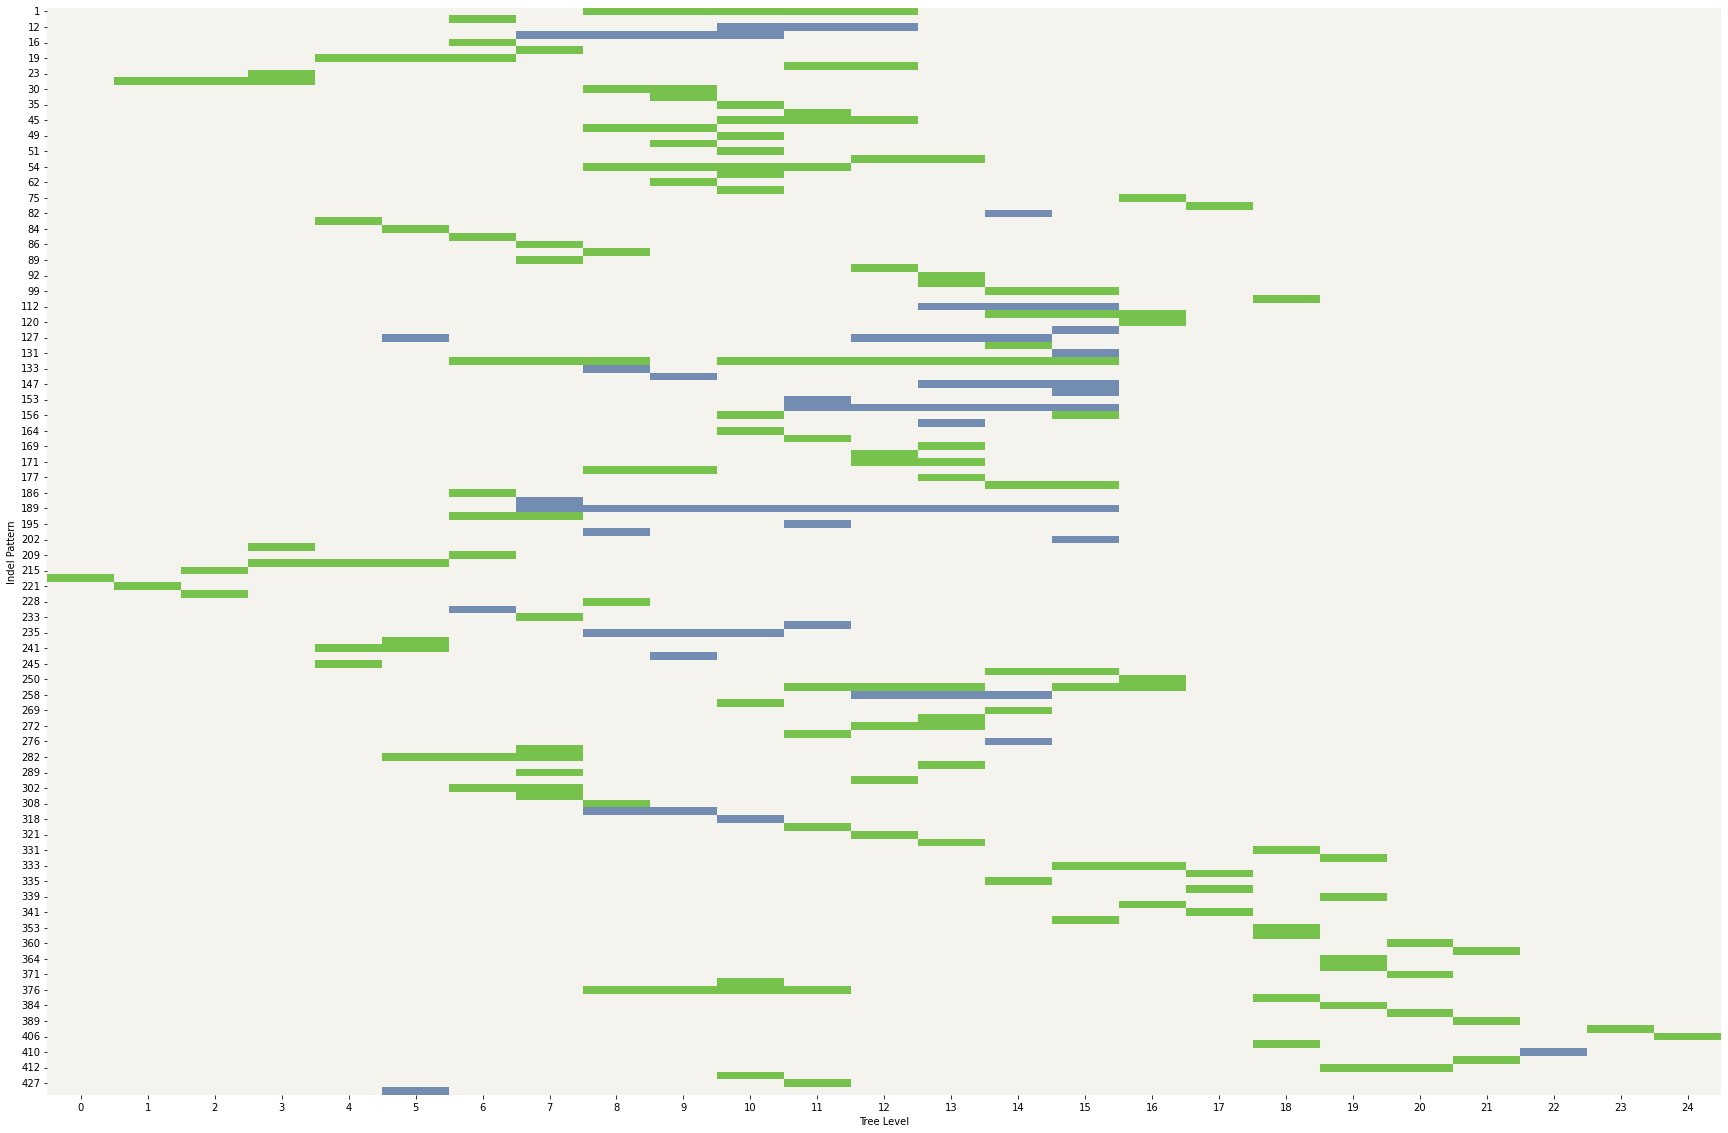

In [105]:
plt.rcParams["figure.figsize"] = [30,20] 
colors = ["#F5F3EE", "#738CB1","#77C24D"] # 1 - extant (blue) , 2 - ancestor(green)
sns_pp = sns.heatmap(mip_indel_df,cmap = colors,cbar=False)
sns_pp.set(xlabel='Tree Level' , ylabel='Indel Pattern')

In [106]:
indel_visual_df1 = pd.DataFrame(sequence_tree_level.items(),columns = ['name','tree_level'])
grp_indel_visual_df2 = pd.DataFrame(grp_sequence_name_pattern_idx.items(),columns = ['name','grp_pattern'])
grp_indel_visual_df3 = pd.DataFrame(grp_sequence_pattern_type.items(),columns = ['name','grp_pattern_type'])
grp_indel_visual_df  = pd.merge(grp_indel_visual_df2, grp_indel_visual_df3, how= "inner" , on="name")
grp_indel_visual_df  = pd.merge(indel_visual_df1, grp_indel_visual_df, how= "inner" , on="name")
grp_indel_df  = grp_indel_visual_df[['grp_pattern','tree_level','grp_pattern_type']]
grp_indel_df  = grp_indel_df.drop_duplicates()
grp_indel_df  = grp_indel_df.pivot(index='grp_pattern', columns= 'tree_level',values = 'grp_pattern_type')
grp_indel_df  = grp_indel_df.fillna(0)
grp_indel_df  = grp_indel_df.astype(int) 
grp_indel_df.head(2)

tree_level,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
grp_pattern,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
7,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[Text(0.5, 159.0, 'Tree Level'), Text(249.0, 0.5, 'Indel Pattern')]

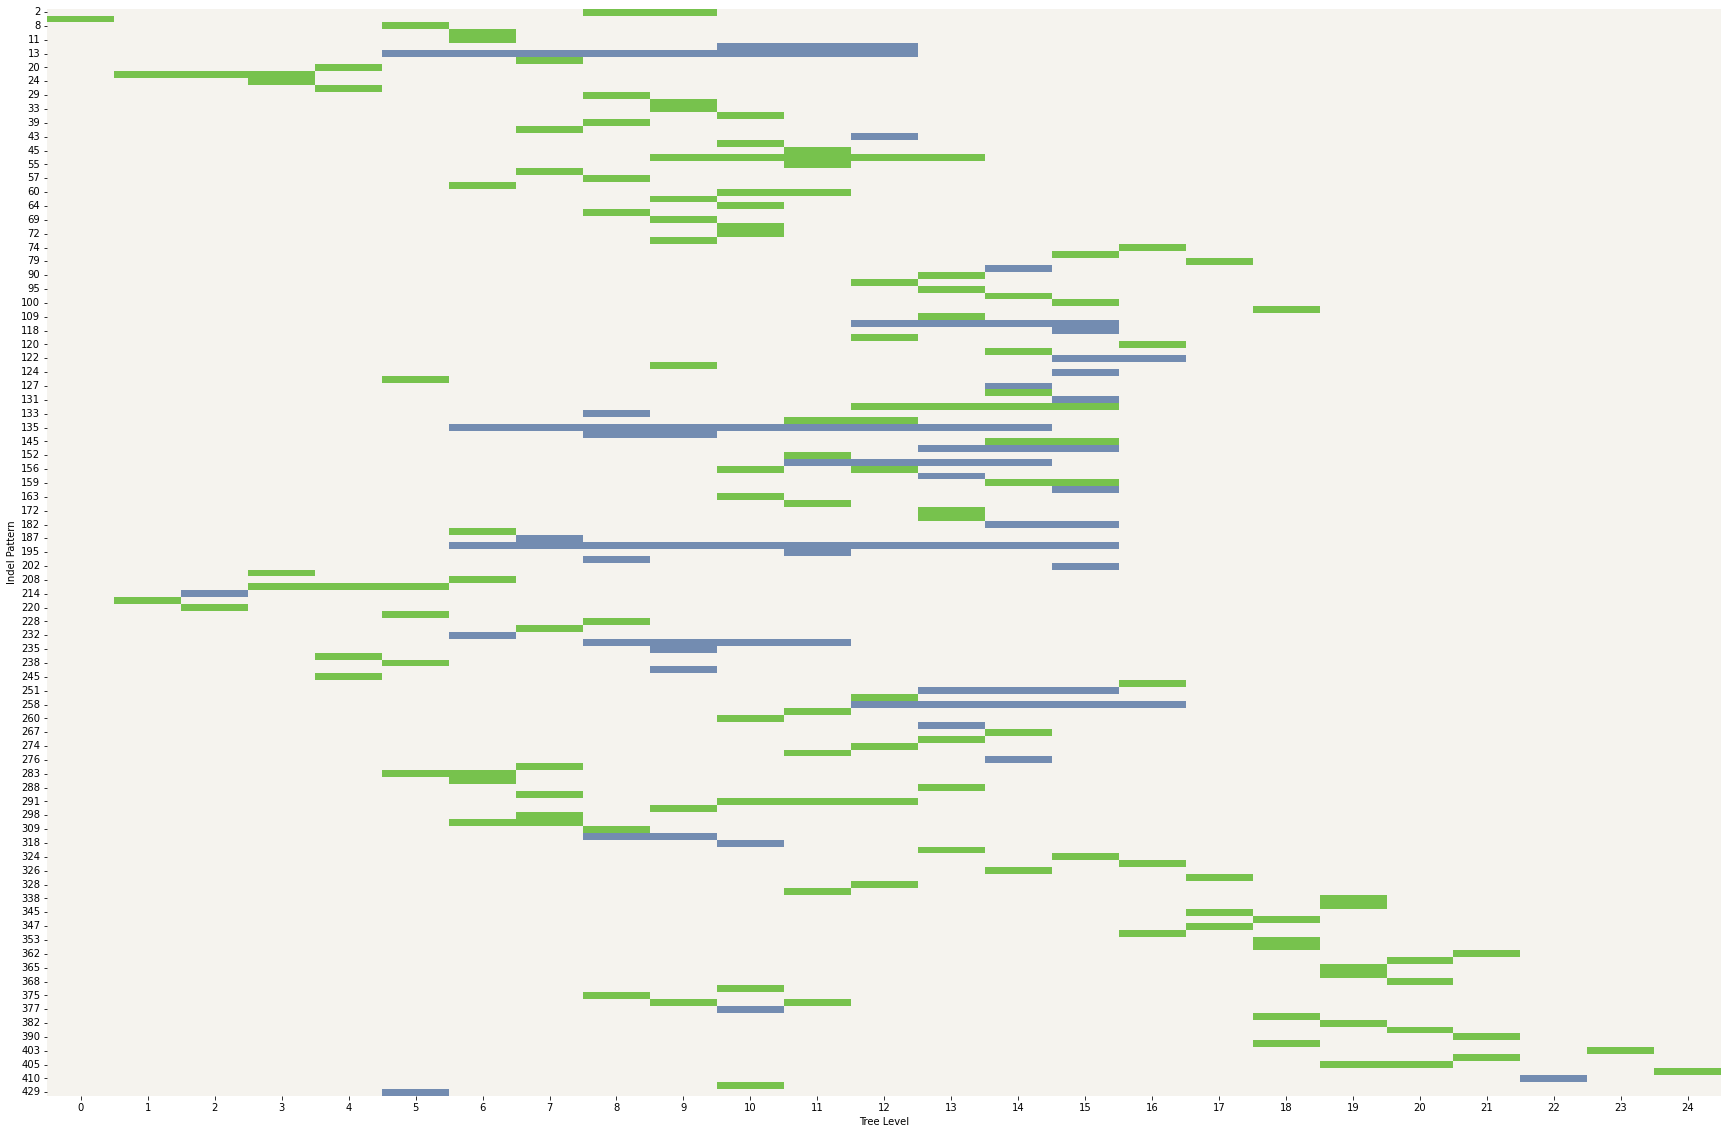

In [107]:
plt.rcParams["figure.figsize"] = [30,20] 
colors = ["#F5F3EE", "#738CB1","#77C24D"] # 1 - extant (blue) , 2 - ancestor(green)
sns_pp = sns.heatmap(grp_indel_df,cmap = colors,cbar=False)
sns_pp.set(xlabel='Tree Level' , ylabel='Indel Pattern')